### Inspecting the data of the Jena weather dataset

In [1]:
import os

data_dir = '/home/richard/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


### Parsing the data

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### Plotting the temperature timeseries

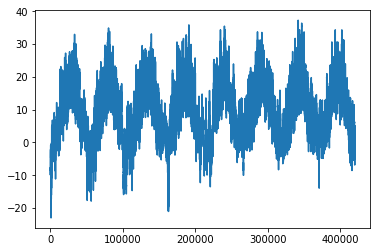

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

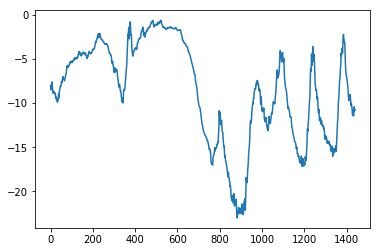

In [5]:
# first 10 days
plt.plot(range(1440), temp[:1440])

### Normalizing the data

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

### Generator yielding timeseries samples and their targets

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

### Preparing the training, validation, and test generators

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size



### Computing the common-sense baseline MAE

In [9]:
# always predict that the temperature 24 hours from now will be equal to the temperature right now
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.289735972991


In [10]:
#  Converting the MAE back to a Celsius error
celsius_mae = 0.2897 * std[1]
print(celsius_mae)

2.56456898411


### A basic machine-learning approach

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 13s - loss: 1.3566 - val_loss: 0.8694
Epoch 2/20
500/500 [==============================] - 8s - loss: 0.4366 - val_loss: 0.3390
Epoch 3/20
500/500 [==============================] - 8s - loss: 0.2886 - val_loss: 0.3069
Epoch 4/20
500/500 [==============================] - 8s - loss: 0.2661 - val_loss: 0.3117
Epoch 5/20
500/500 [==============================] - 8s - loss: 0.2526 - val_loss: 0.3033
Epoch 6/20
500/500 [==============================] - 8s - loss: 0.2443 - val_loss: 0.3136
Epoch 7/20
500/500 [==============================] - 8s - loss: 0.2371 - val_loss: 0.3234
Epoch 8/20
500/500 [==============================] - 8s - loss: 0.2316 - val_loss: 0.3391
Epoch 9/20
500/500 [==============================] - 8s - loss: 0.2273 - val_loss: 0.3265
Epoch 10/20
500/500 [==============================] - 8s - loss: 0.2206 - val_loss: 0.3342
Epoch 11/20
500/500 [==============================] - 8s - loss: 0.2183 - val_loss: 0.3

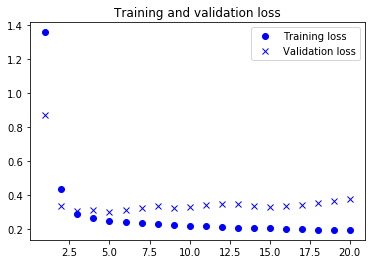

In [16]:
import matplotlib.pyplot as plt

# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# plt.figure(figsize=(20, 6))
# plt.subplot(1, 2, 1)

# plt.plot(epochs, acc, label='Training acc')
# plt.plot(epochs, val_acc, label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'bx', label='Validation loss')
# plt.ylim([0.15,0.4])
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Training and evaluating a GRU-based model

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 127s - loss: 0.3107 - val_loss: 0.2789
Epoch 2/20
500/500 [==============================] - 127s - loss: 0.2868 - val_loss: 0.2697
Epoch 3/20
500/500 [==============================] - 127s - loss: 0.2777 - val_loss: 0.2707
Epoch 4/20
500/500 [==============================] - 126s - loss: 0.2736 - val_loss: 0.2656
Epoch 5/20
500/500 [==============================] - 127s - loss: 0.2698 - val_loss: 0.2674
Epoch 6/20
500/500 [==============================] - 126s - loss: 0.2670 - val_loss: 0.2655
Epoch 7/20
500/500 [==============================] - 126s - loss: 0.2611 - val_loss: 0.2729
Epoch 8/20
500/500 [==============================] - 126s - loss: 0.2569 - val_loss: 0.2758
Epoch 9/20
500/500 [==============================] - 126s - loss: 0.2537 - val_loss: 0.2886
Epoch 10/20
500/500 [==============================] - 126s - loss: 0.2463 - val_loss: 0.2826
Epoch 11/20
500/500 [==============================] - 126s - loss: 0

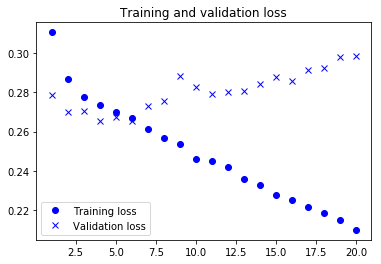

In [18]:
import matplotlib.pyplot as plt

# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# plt.figure(figsize=(20, 6))
# plt.subplot(1, 2, 1)

# plt.plot(epochs, acc, label='Training acc')
# plt.plot(epochs, val_acc, label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'bx', label='Validation loss')
# plt.ylim([0.15,0.4])
plt.title('Training and validation loss')
plt.legend()

plt.show()

### GRU with Recurrent Dropout

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 137s - loss: 0.3440 - val_loss: 0.2745
Epoch 2/20
500/500 [==============================] - 132s - loss: 0.3150 - val_loss: 0.2708
Epoch 3/20
500/500 [==============================] - 131s - loss: 0.3088 - val_loss: 0.2714
Epoch 4/20
500/500 [==============================] - 133s - loss: 0.3050 - val_loss: 0.2691
Epoch 5/20
500/500 [==============================] - 131s - loss: 0.3012 - val_loss: 0.2666
Epoch 6/20
500/500 [==============================] - 131s - loss: 0.2982 - val_loss: 0.2670
Epoch 7/20
500/500 [==============================] - 132s - loss: 0.2965 - val_loss: 0.2643
Epoch 8/20
500/500 [==============================] - 132s - loss: 0.2969 - val_loss: 0.2650
Epoch 9/20
500/500 [==============================] - 133s - loss: 0.2925 - val_loss: 0.2637
Epoch 10/20
500/500 [==============================] - 132s - loss: 0.2910 - val_loss: 0.2636
Epoch 11/20
500/500 [==============================] - 131s - loss: 0

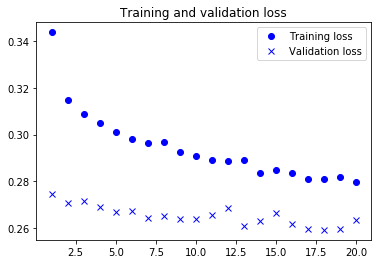

In [12]:
import matplotlib.pyplot as plt

# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# plt.figure(figsize=(20, 6))
# plt.subplot(1, 2, 1)

# plt.plot(epochs, acc, label='Training acc')
# plt.plot(epochs, val_acc, label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'bx', label='Validation loss')
# plt.ylim([0.15,0.4])
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Stacked GRU with Recurrent Dropout

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
import matplotlib.pyplot as plt

# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# plt.figure(figsize=(20, 6))
# plt.subplot(1, 2, 1)

# plt.plot(epochs, acc, label='Training acc')
# plt.plot(epochs, val_acc, label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'bx', label='Validation loss')
# plt.ylim([0.15,0.4])
plt.title('Training and validation loss')
plt.legend()

plt.show()